In [1]:
#RHC Example

#install packages (if needed)
install.packages("tableone")
install.packages("ipw")
install.packages("sandwich")
install.packages("survey")

#load packages
library(tableone)
library(ipw)
library(sandwich) #for robust variance estimation
library(survey)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: grid

Loading required package: Matrix

Loading required package: survival


Attaching package: ‘survey’


The following object is masked from ‘package:graphics’:

    dotchart




## Load & Create a Data Set 

In [8]:
#read in data
load(url("http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/rhc.sav"))
#view data

#treatment variables is swang1
#x variables that we will use
#cat1: primary disease category
#age
#sex
#meanbp1: mean blood pressure

#create a data set with just these variables, for simplicity
ARF<-as.numeric(rhc$cat1=='ARF')
CHF<-as.numeric(rhc$cat1=='CHF')
Cirr<-as.numeric(rhc$cat1=='Cirrhosis')
colcan<-as.numeric(rhc$cat1=='Colon Cancer')
Coma<-as.numeric(rhc$cat1=='Coma')
COPD<-as.numeric(rhc$cat1=='COPD')
lungcan<-as.numeric(rhc$cat1=='Lung Cancer')
MOSF<-as.numeric(rhc$cat1=='MOSF w/Malignancy')
sepsis<-as.numeric(rhc$cat1=='MOSF w/Sepsis')
female<-as.numeric(rhc$sex=='Female')
died<-as.integer(rhc$death=='Yes')
age<-rhc$age
treatment<-as.numeric(rhc$swang1=='RHC')
meanbp1<-rhc$meanbp1

#new dataset
mydata<-cbind(ARF,CHF,Cirr,colcan,Coma,lungcan,MOSF,sepsis,
              age,female,meanbp1,treatment,died)
mydata<-data.frame(mydata)

#covariates we will use (shorter list than you would use in practice)
xvars<-c("age","female","meanbp1","ARF","CHF","Cirr","colcan",
         "Coma","lungcan","MOSF","sepsis")


## Stratrifying Data Based on Treatment 

In [12]:
table1<- CreateTableOne(vars=xvars,strata="treatment", data=mydata, test=FALSE)
## include standardized mean difference (SMD)
print(table1,smd=TRUE)


                     Stratified by treatment
                      0             1             SMD   
  n                    3551          2184               
  age (mean (SD))     61.76 (17.29) 60.75 (15.63)  0.061
  female (mean (SD))   0.46 (0.50)   0.41 (0.49)   0.093
  meanbp1 (mean (SD)) 84.87 (38.87) 68.20 (34.24)  0.455
  ARF (mean (SD))      0.45 (0.50)   0.42 (0.49)   0.059
  CHF (mean (SD))      0.07 (0.25)   0.10 (0.29)   0.095
  Cirr (mean (SD))     0.05 (0.22)   0.02 (0.15)   0.145
  colcan (mean (SD))   0.00 (0.04)   0.00 (0.02)   0.038
  Coma (mean (SD))     0.10 (0.29)   0.04 (0.20)   0.207
  lungcan (mean (SD))  0.01 (0.10)   0.00 (0.05)   0.095
  MOSF (mean (SD))     0.07 (0.25)   0.07 (0.26)   0.018
  sepsis (mean (SD))   0.15 (0.36)   0.32 (0.47)   0.415


## Weighted Propensity Score Model

In [16]:
psmodel <- glm(treatment ~ age + female + meanbp1+ARF+CHF+Cirr+colcan+
         Coma+lungcan+MOSF+sepsis,
               family  = binomial(link ="logit"))
########################### Create scores ###################
ps<-predict(psmodel,type='response')
############################ Create Weights #################
weight<-ifelse(treatment==1,1/(ps),1/(1-ps))
############################ Weighted Data #####################
weighteddata<-svydesign(ids = ~ 1, data =mydata, weights = ~ weight)
weightedtable <-svyCreateTableOne(vars = xvars, strata = "treatment", 
                                 data = weighteddata, test = FALSE)
## Show table with SMD
print(weightedtable, smd = TRUE)


                     Stratified by treatment
                      0               1               SMD   
  n                   5732.49         5744.88               
  age (mean (SD))       61.36 (17.56)   61.43 (15.33)  0.004
  female (mean (SD))     0.45 (0.50)     0.45 (0.50)   0.001
  meanbp1 (mean (SD))   78.60 (37.58)   79.26 (40.31)  0.017
  ARF (mean (SD))        0.44 (0.50)     0.44 (0.50)   0.010
  CHF (mean (SD))        0.08 (0.27)     0.08 (0.27)   0.005
  Cirr (mean (SD))       0.04 (0.19)     0.04 (0.19)   0.001
  colcan (mean (SD))     0.00 (0.04)     0.00 (0.06)   0.042
  Coma (mean (SD))       0.08 (0.26)     0.07 (0.25)   0.023
  lungcan (mean (SD))    0.01 (0.08)     0.01 (0.09)   0.014
  MOSF (mean (SD))       0.07 (0.26)     0.07 (0.26)   0.004
  sepsis (mean (SD))     0.21 (0.41)     0.22 (0.41)   0.002


## Causal Risk Difference (ipw Package)

In [20]:
weightmodel<-ipwpoint(exposure= treatment, family = "binomial", link ="logit",
          denominator= ~ age + female + meanbp1+ARF+CHF+Cirr+colcan+
           Coma+lungcan+MOSF+sepsis, data=mydata)
#numeric summary of weights
summary(weightmodel$ipw.weights)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.046   1.405   1.721   2.001   2.280  21.606 

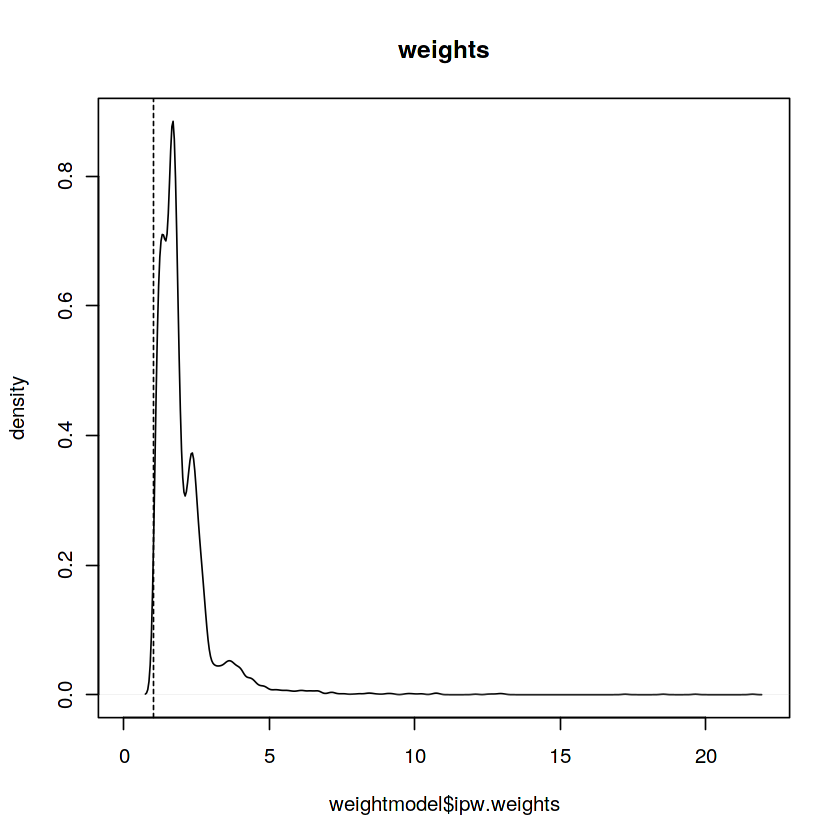

In [21]:
ipwplot(weights = weightmodel$ipw.weights, logscale = FALSE,
         main = "weights", xlim = c(0, 22))

## Fit a Marginal Structure Model (Risk Diff)

In [25]:
mydata$wt<-weightmodel$ipw.weights
msm <- (svyglm(died ~ treatment, design = svydesign(~ 1, weights = ~wt,
                  data =mydata)))
coef(msm)
confint(msm)

(Intercept)   treatment 
 0.63046375  0.05154951

,2.5 %,97.5 %
(Intercept),0.61401445,0.64691305
treatment,0.02333029,0.07976873


## Fit propensity score model to get weights, but truncated

In [26]:
weightmodel<-ipwpoint(exposure= treatment, family = "binomial", link ="logit",
                      denominator= ~ age + female + meanbp1+ARF+CHF+Cirr+colcan+
                        Coma+lungcan+MOSF+sepsis, data=mydata,trunc=.01)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.081   1.405   1.721   1.972   2.280   6.379 

(Intercept)   treatment 
 0.63045533  0.05494865

,2.5 %,97.5 %
(Intercept),0.61400659,0.64690406
treatment,0.02822931,0.08166799


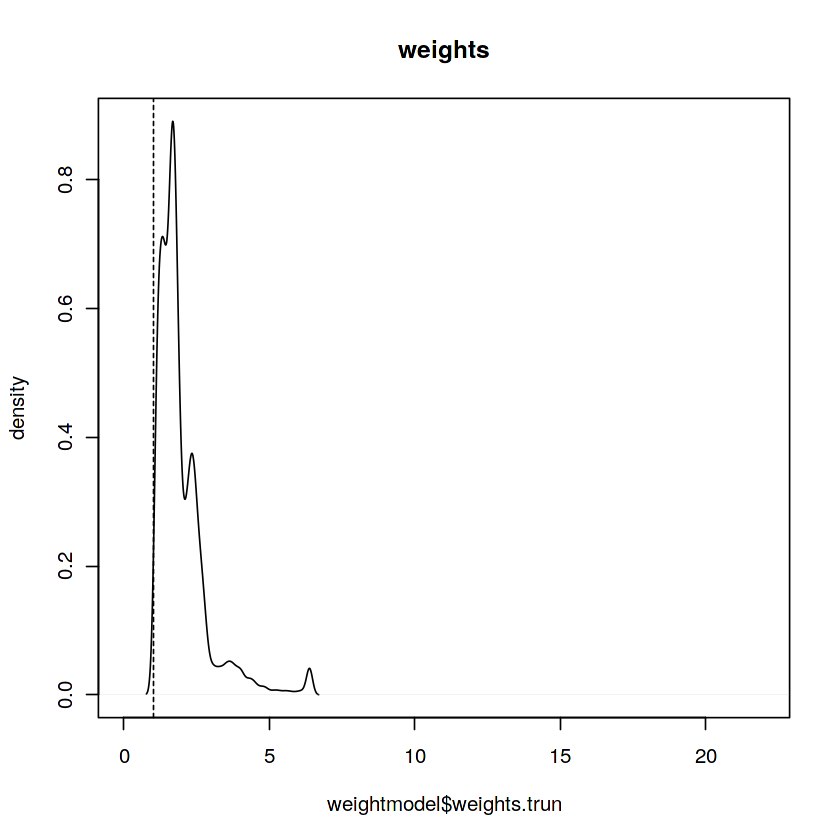

In [27]:
#numeric summary of weights
summary(weightmodel$weights.trun)
#plot of weights
ipwplot(weights = weightmodel$weights.trun, logscale = FALSE,
        main = "weights", xlim = c(0, 22))
mydata$wt<-weightmodel$weights.trun
#fit a marginal structural model (risk difference)
msm <- (svyglm(died ~ treatment, design = svydesign(~ 1, weights = ~wt,
                                                    data =mydata)))
coef(msm)
confint(msm)